# After sales text clustering using TF-IDF and KMeans

## Data preprocessing (Merging the translated text)

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [3]:
def query_data(query):
    """
    Function to query data from the database using sqlalchemy
    :param query: 
    :return: pd.DataFrame
    
    Connection parameters:
    user = readmyzone
    password = (get from environment variable MYSQL_PASSWORD)
    host = 192.168.2.7
    port = 3306
    """
    
    # Create the connection string
    user = 'readmyzone'
    password = os.environ.get('MYSQL_PASSWORD')
    host = '192.168.2.7'
    port = '3306'
    db = 'myzone'
    connection_string = f'mysql+pymysql://{user}:{password}@{host}:{port}/{db}'
    
    # Create the engine
    engine = create_engine(connection_string)
    
    try:
        # Query the data
        data = pd.read_sql(query, engine)
    except Exception as e:
        print(e)
        data = None
    
    return data

# Load the data

In [4]:
sav_incidencias = query_data('SELECT * FROM sav_incidencias')
sav_piezas = query_data('SELECT * FROM sav_piezas')
sav_estados = query_data('SELECT * FROM sav_estados')
sav_incidencias_tipo = query_data('SELECT * FROM sav_incidencias_tipo')

In [5]:
dataset = sav_incidencias.merge(sav_piezas, left_on='codigo', right_on='codigo_incidencia', how='left', suffixes=(None, '_pieza'))
dataset = dataset.merge(sav_estados, left_on='estado', right_on='id', how='left', suffixes=(None, '_estado'))
dataset = dataset.merge(sav_incidencias_tipo, left_on='tipo', right_on='id', how='left', suffixes=(None, '_tipo'))

In [6]:
clean_dataset = dataset[(dataset["tipo"] == 1) & (dataset["estado"].isin([2,6]))]

In [7]:
# Load from disk the text to translate dictionary
fields_to_translate = ["desc_problema", "problema", "descripcion"]
text_to_translate = {}
for text in fields_to_translate:
    text_to_translate[text] = pd.read_csv(f"../DATA/{text}.csv", sep='¬', encoding='utf-8-sig')

C:\Users\voliveira\AppData\Local\Temp\ipykernel_19640\1421433580.py:5: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  text_to_translate[text] = pd.read_csv(f"../DATA/{text}.csv", sep='¬', encoding='utf-8-sig')
C:\Users\voliveira\AppData\Local\Temp\ipykernel_19640\1421433580.py:5: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  text_to_translate[text] = pd.read_csv(f"../DATA/{text}.csv", sep='¬', encoding='utf-8-sig')
C:\Users\voliveira\AppData\Local\Temp\ipykernel_19640\1421433580.py:5: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; 

In [8]:
desc_problema_translated = pd.read_csv("../DATA/desc_problema_translated.csv", sep='¬', encoding='utf-8-sig', engine='python')
descripcion_translated = pd.read_csv("../DATA/descripcion_translated.csv", sep='¬', encoding='utf-8-sig', engine='python')
problema_translated = pd.read_csv("../DATA/problema_translated.csv", sep='¬', encoding='utf-8-sig', engine='python')# Data preprocessing (Merging the translated text)

In [9]:
# Delete rows with values (desc_problema, desc_problema_translated)
desc_problema_translated = desc_problema_translated[~desc_problema_translated["desc_problema_translated"].isin(["desc_problema_translated"])]
descripcion_translated = descripcion_translated[~descripcion_translated["descripcion_translated"].isin(["descripcion_translated"])]
problema_translated = problema_translated[~problema_translated["problema_translated"].isin(["problema_translated"])]

In [10]:
desc_problema_translated.count()

desc_problema               18099
desc_problema_translated    18099
dtype: int64

In [11]:
# Merge the translated text with the text_to_translate dataframe
desc_problema_translated = text_to_translate["desc_problema"].merge(desc_problema_translated, left_on="desc_problema", right_on="desc_problema", how="left")
descripcion_translated = text_to_translate["descripcion"].merge(descripcion_translated, left_on="descripcion", right_on="descripcion", how="left")
problema_translated = text_to_translate["problema"].merge(problema_translated, left_on="problema", right_on="problema", how="left")

In [12]:
# Fill NA with the original texts
desc_problema_translated.fillna({"desc_problema_translated": desc_problema_translated["desc_problema"]}, inplace=True)
descripcion_translated.fillna({"descripcion_translated": descripcion_translated["descripcion"]}, inplace=True)
problema_translated.fillna({"problema_translated": problema_translated["problema"]}, inplace=True)

In [13]:
desc_problema_translated.head(5)

,desc_problema,desc_problema_lg,desc_problema_translated
0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,es,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...
1,NO FUNCIONA,es,NO FUNCIONA
2,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,es,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...
3,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,es,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...
4,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",es,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR"


In [14]:
# Merge the translated text with the original dataset
clean_dataset = clean_dataset.merge(desc_problema_translated, left_on="desc_problema", right_on="desc_problema", how="left")
clean_dataset = clean_dataset.merge(descripcion_translated, left_on="descripcion", right_on="descripcion", how="left")
clean_dataset = clean_dataset.merge(problema_translated, left_on="problema", right_on="problema", how="left")

In [15]:
clean_dataset[["desc_problema"]].head(100)

,desc_problema
0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...
1,NO FUNCIONA
2,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...
3,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...
4,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR"
...,...
95,"por favor sacar este material a mi nombre, es ..."
96,"por favor sacar este material a mi nombre, es ..."
97,Pasarela Daikin: unos 3 minutos despues de arr...
98,Rejilla no funciona. Enviar una nueva retirar ...


In [16]:
clean_dataset.describe(include='all')

,id,web_id,codigo,creation_date,modification_date,company_id,user_id,ref_cliente,portes_airzone,devaluacion,...,titulo_en_tipo,titulo_fr_tipo,titulo_it_tipo,titulo_pt_tipo,desc_problema_lg,desc_problema_translated,descripcion_lg,descripcion_translated,problema_lg,problema_translated
count,44870.000000,44870.000000,44870,44870,44870,44870.000000,44870.000000,44848,44870.000000,44870.000000,...,44870,44870,44870,0,42131,42131,35105,33289,44834,43018
unique,NaN,NaN,34709,34666,28441,NaN,NaN,29831,NaN,NaN,...,1,1,1,0,33,28057,33,11384,33,29748
top,NaN,NaN,MPMAMZZN0E,2023-11-19 14:06:28,0000-00-00 00:00:00,NaN,NaN,RESO MATERIALE ASSISTENZE,NaN,NaN,...,guarantee,garantie,garanzia,NaN,es,NO FUNCIONA,en,TERMOSTATO,es,NO FUNCIONA
freq,NaN,NaN,38,38,7756,NaN,NaN,278,NaN,NaN,...,44870,44870,44870,NaN,15026,540,8597,735,14392,953
mean,31075.868041,1.636260,NaN,NaN,NaN,1341.928081,2708.666994,NaN,0.999265,0.000446,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.000000,1.000000,NaN,NaN,NaN,0.000000,1.000000,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,17417.250000,1.000000,NaN,NaN,NaN,240.000000,469.000000,NaN,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,32110.000000,2.000000,NaN,NaN,NaN,492.000000,1953.000000,NaN,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,45158.750000,2.000000,NaN,NaN,NaN,1935.000000,4230.000000,NaN,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,58791.000000,5.000000,NaN,NaN,NaN,7632.000000,10284.000000,NaN,1.000000,20.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
for column in clean_dataset.columns:
    print(f"Column: {column}")

Column: id
Column: web_id
Column: codigo
Column: creation_date
Column: modification_date
Column: company_id
Column: user_id
Column: ref_cliente
Column: portes_airzone
Column: devaluacion
Column: pedido_sage
Column: abono_sage
Column: pedido_a3
Column: abono_a3
Column: tipo
Column: estado
Column: personaaz
Column: dire_envio_id
Column: dire_recogida_id
Column: peso3
Column: volumen3
Column: estadofr
Column: c_mail
Column: c_tel
Column: c_obs
Column: accepted_client
Column: desc_problema
Column: codigo_incidencia
Column: id_pieza
Column: user_id_pieza
Column: cod_articulo
Column: descripcion
Column: num_serie
Column: factura_albaran
Column: problema
Column: is_replacement
Column: creation_date_pieza
Column: modification_date_pieza
Column: id_estado
Column: ref
Column: color
Column: valor
Column: titulo_es
Column: titulo_en
Column: titulo_fr
Column: titulo_it
Column: titulo_pt
Column: id_tipo
Column: titulo_es_tipo
Column: titulo_en_tipo
Column: titulo_fr_tipo
Column: titulo_it_tipo
Colum

In [58]:
# Get only the columns with the fields of interest
text_to_analyse = clean_dataset[['desc_problema_translated','descripcion_translated','problema_translated','cod_articulo']]
# Fill NA with empty string
text_to_analyse.fillna("", inplace=True)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_19640\3066680078.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_to_analyse.fillna("", inplace=True)


In [59]:
text_to_analyse.loc[:, 'text_to_analyse'] = text_to_analyse['desc_problema_translated'] + ' ' + text_to_analyse['descripcion_translated'] + ' ' + text_to_analyse['problema_translated'] + ' ' + text_to_analyse['cod_articulo']

C:\Users\voliveira\AppData\Local\Temp\ipykernel_19640\2023409095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_to_analyse.loc[:, 'text_to_analyse'] = text_to_analyse['desc_problema_translated'] + ' ' + text_to_analyse['descripcion_translated'] + ' ' + text_to_analyse['problema_translated'] + ' ' + text_to_analyse['cod_articulo']


In [60]:
text_to_analyse.head(10)

,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse
0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MODULO ALARMAS TECNICAS,INDICAN SE HA ESTROPEADO EN LA INSTALACION Y ...,MATS,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...
1,NO FUNCIONA,,NO FUNCIONA,AZC3TACTOCSB,NO FUNCIONA NO FUNCIONA AZC3TACTOCSB
2,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,,TACTO BLOQUEADO. NO ENCIENDE-APAGA NI DEJA CAM...,AZATACTORSB,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...
3,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,MODELO 2 PERSIANAS,UNA DE LAS 2 PERSIANAS NO FUNCIONA CON PULSADO...,PER2,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...
4,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",,Rafael el viernes llego mi pedido nº 23349 pa...,RINT040015BKMTE,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR Rafa..."
5,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,MODULO DE FANCOIL DE ZONA 32Z,AZAMFANCOILC,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...
6,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,MODULO DE FANCOIL DE ZONA 32Z,"SE DETECTA QUE EL BLUEFACE AL ENCENDERLO, SE Q...",AZAMFANCOILC,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...
7,"Error al pedir la pasarela, a última hora hubo...",Pasarela Mitsubishi Heavy,"Error comercial, por cambio de última hora en ...",AZXEQADAPMHI,"Error al pedir la pasarela, a última hora hubo..."
8,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,,SE ROMPEN TAPAS TRASERAS. CAMBIAR TERMOSTATO.,AZC3BLUEFECOSB,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...
9,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,,5 UNIDADES. SE ROMPEN TAPAS TRASERAS.,AZC3TACTOCSB,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...


## Apply TF-IDF and KMeans clustering

In [61]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import string
# Download the stopwords and punkt
nltk.download('stopwords')
nltk.download('punkt')

def pre_process_text(text):
    """
    Function to preprocess the text
    Use nltk library to preprocess the text and return the preprocessed text
    Tokenize the text, remove stopwords, remove punctuation, lowercase the text
    :param text: text to preprocess
    :return: preprocessed text
    """
    try:
        text = str(text) # Convert all entries to string
    except Exception as e:
        print(f"Error occurred during text conversion: {e}")
        return ''
    # Create the stopwords list
    stop_words = set(stopwords.words('spanish'))
    # Create the stemmer
    stemmer = SnowballStemmer('spanish')
    # Tokenize the text
    tokens = word_tokenize(text)
    #print(f'After tokenizer: {tokens}')
    # Remove the stopwords
    tokens = [word for word in tokens if word.lower() not in stop_words]
    #print(f'After remove stop words: {tokens}')
    # Remove the punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    #print(f'After remove punctuation: {tokens}')
    # Lowercase the text
    tokens = [word.lower() for word in tokens]
    #print(f'After lowercase words: {tokens}')
    # Stem the words
    tokens = [stemmer.stem(word) for word in tokens]
    # print(f'After Stemmer: {tokens}')
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\voliveira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\voliveira\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [62]:
example_text = 'Hola, esto es un ejemplo de texto que vamos a preprocesar para testear'
pre_process_text(example_text)

'hol ejempl text vam preproces test'

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase=False, preprocessor=pre_process_text, min_df=0.01, max_df=0.99)
vector = vectorizer.fit_transform(text_to_analyse['text_to_analyse'])
vector = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out())

In [64]:
vector.sum().sort_values(ascending=False)

termostat    3521.931648
funcion      2951.396888
motor        1887.536316
airzon       1647.707807
bolet        1582.804881
                ...     
continu       180.067282
siguient      180.015421
codig         176.963472
deb           164.893583
ott           157.308615
Length: 196, dtype: float64

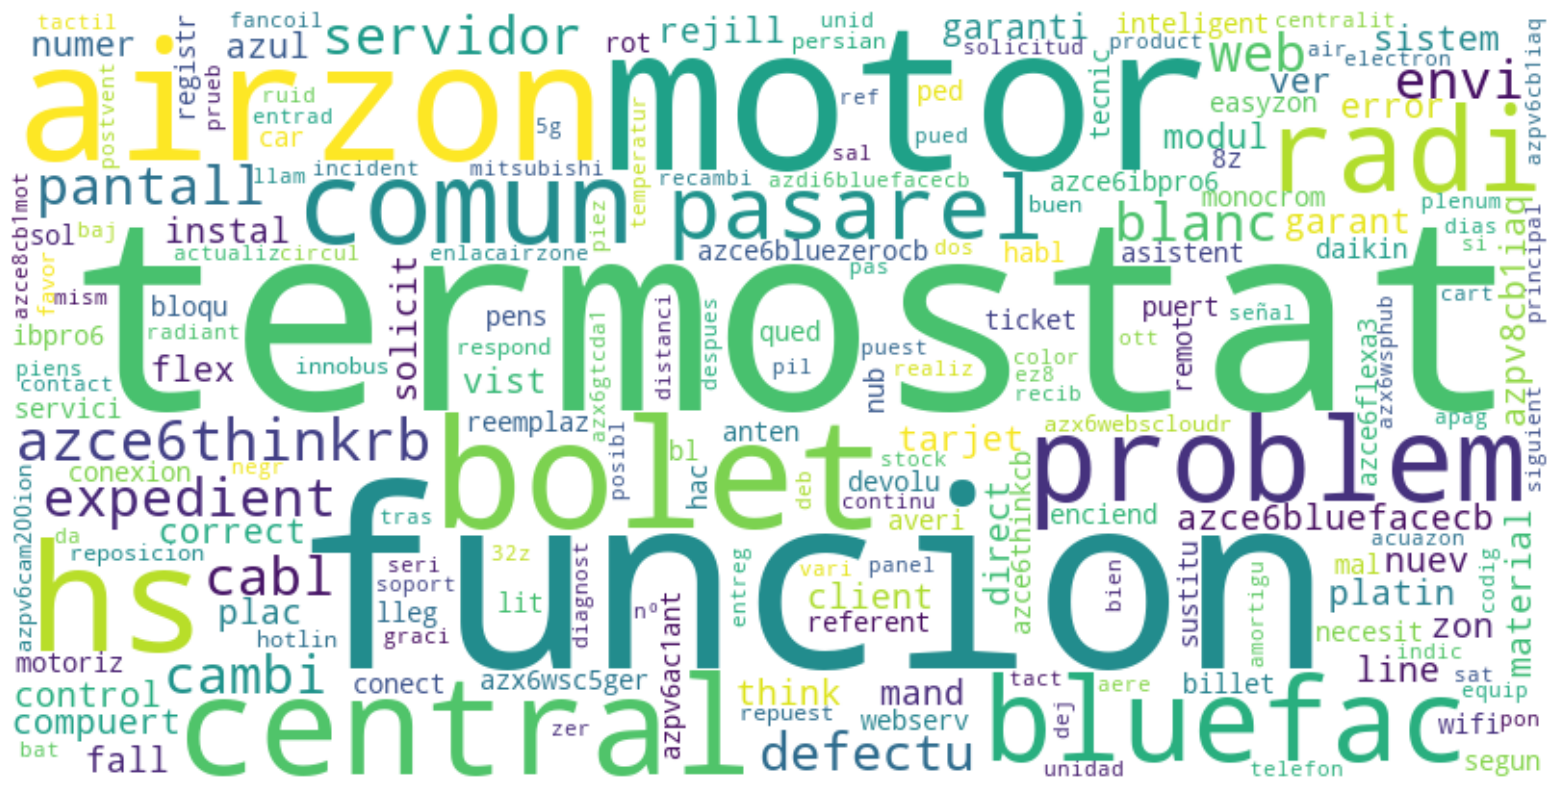

In [66]:
# Create a cloud of words with the most common words
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(vector.sum().to_dict())
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

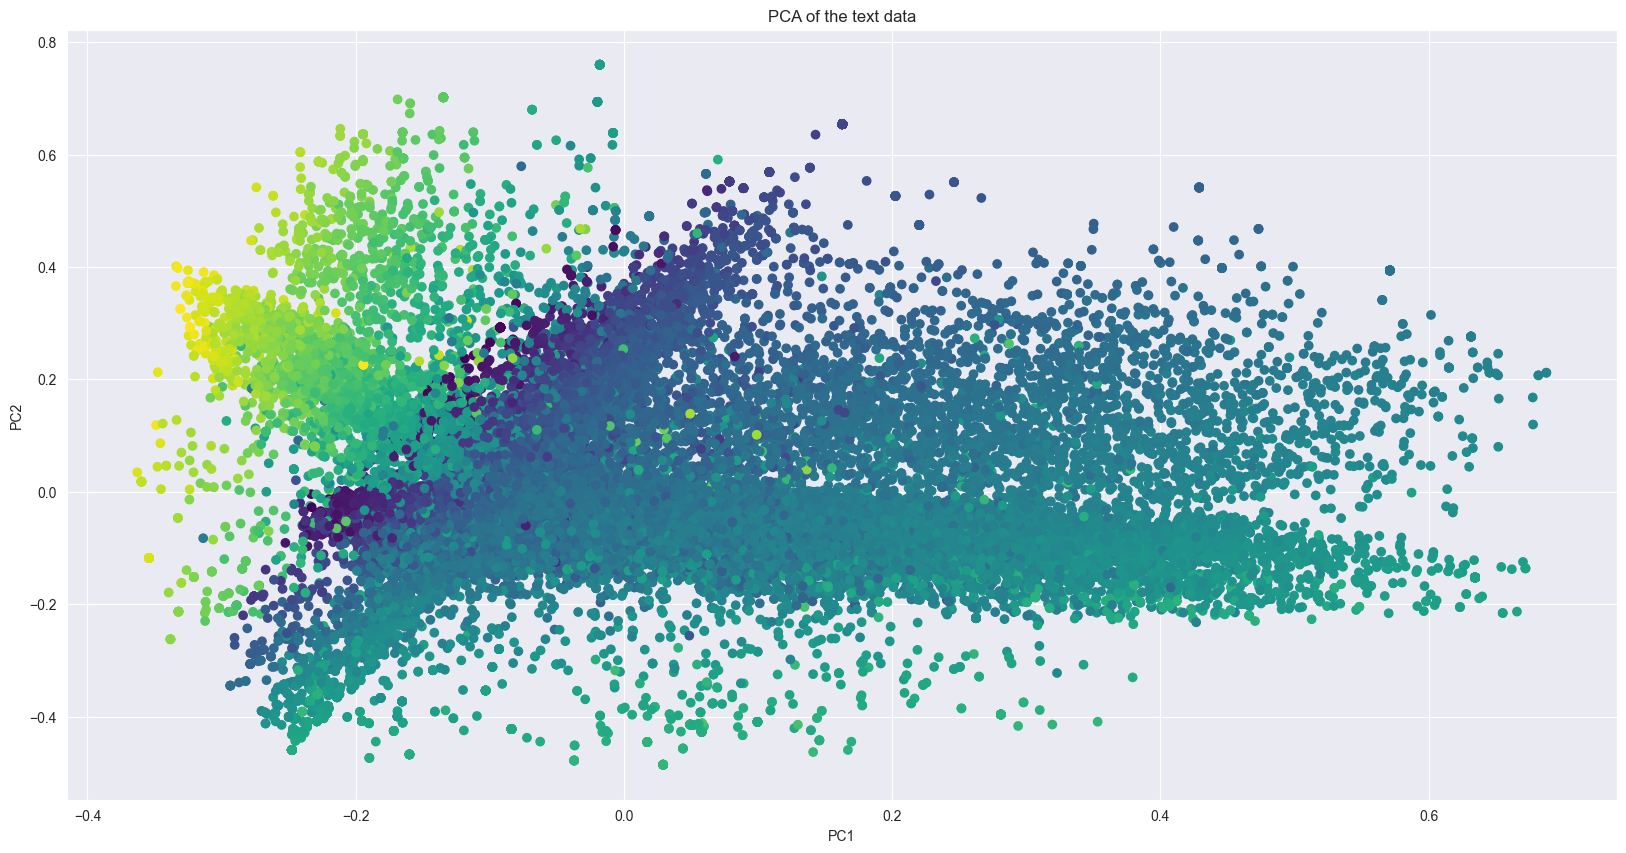

In [67]:
# Use PCA to reduce the dimensionality of the data
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_vector = pca.fit_transform(vector)
pca_vector = pd.DataFrame(pca_vector, columns=['PC1', 'PC2', 'PC3'])

plt.figure(figsize=(20, 10))
plt.scatter(pca_vector['PC1'], pca_vector['PC2'], c=pca_vector['PC3'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of the text data')
plt.show()

In [68]:
# Plotting in 3D
%matplotlib qt
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_vector['PC1'], pca_vector['PC2'], pca_vector['PC3'], c=pca_vector['PC3'], cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA of the text data')
plt.show()

In [69]:
%matplotlib inline

In [70]:
# Use another dimensionality reduction technique
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
tsne_vector = tsne.fit_transform(vector)
tsne_vector = pd.DataFrame(tsne_vector, columns=['TSNE1', 'TSNE2', 'TSNE3'])

In [71]:
%matplotlib qt
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_vector['TSNE1'], tsne_vector['TSNE2'], tsne_vector['TSNE3'], c=tsne_vector['TSNE3'], cmap='viridis')
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_zlabel('TSNE3')
plt.title('TSNE of the text data')
plt.show()

In [38]:
%matplotlib inline

In [78]:
# Create a sklearn pipeline to apply a clustering algorithm
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('kmeans', KMeans())
])

# Create grid search parameters
parameters = {
    'kmeans__n_clusters': [75, 80, 95, 100, 105, 110, 115, 120, 130, 140, 150, 160, 170, 180, 190, 200]
}

grid_search = GridSearchCV(pipeline, parameters, cv=2, n_jobs=-1, verbose=1)
grid_search.fit(vector)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


GridSearchCV(cv=2, estimator=Pipeline(steps=[('kmeans', KMeans())]), n_jobs=-1,
             param_grid={'kmeans__n_clusters': [75, 80, 95, 100, 105, 110, 115,
                                                120, 130, 140, 150, 160, 170,
                                                180, 190, 200]},
             verbose=1)

In [79]:
# Check the best parameters
grid_search.best_params_

{'kmeans__n_clusters': 200}

In [80]:
# Add the cluster to the dataset
text_to_analyse['cluster'] = grid_search.best_estimator_.predict(vector)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_19640\667776019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_to_analyse['cluster'] = grid_search.best_estimator_.predict(vector)


In [75]:
# Plot the clusters
%matplotlib qt

# Plotting code
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_vector['PC1'], pca_vector['PC2'], pca_vector['PC3'], c=text_to_analyse['cluster'], cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA of the text data')
plt.show()

In [81]:
# Plot the clusters
%matplotlib qt

# Plotting code
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_vector['TSNE1'], tsne_vector['TSNE2'], tsne_vector['TSNE3'], c=text_to_analyse['cluster'], cmap='viridis')
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_zlabel('TSNE3')
plt.title('After sales text clustering')
plt.show()

In [52]:
%matplotlib inline

In [82]:
text_to_analyse.head(10)

,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,cluster
0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MODULO ALARMAS TECNICAS,INDICAN SE HA ESTROPEADO EN LA INSTALACION Y ...,MATS,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,1
1,NO FUNCIONA,,NO FUNCIONA,AZC3TACTOCSB,NO FUNCIONA NO FUNCIONA AZC3TACTOCSB,93
2,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,,TACTO BLOQUEADO. NO ENCIENDE-APAGA NI DEJA CAM...,AZATACTORSB,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,155
3,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,MODELO 2 PERSIANAS,UNA DE LAS 2 PERSIANAS NO FUNCIONA CON PULSADO...,PER2,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,29
4,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",,Rafael el viernes llego mi pedido nº 23349 pa...,RINT040015BKMTE,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR Rafa...",85
5,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,MODULO DE FANCOIL DE ZONA 32Z,AZAMFANCOILC,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,100
6,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,MODULO DE FANCOIL DE ZONA 32Z,"SE DETECTA QUE EL BLUEFACE AL ENCENDERLO, SE Q...",AZAMFANCOILC,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,100
7,"Error al pedir la pasarela, a última hora hubo...",Pasarela Mitsubishi Heavy,"Error comercial, por cambio de última hora en ...",AZXEQADAPMHI,"Error al pedir la pasarela, a última hora hubo...",144
8,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,,SE ROMPEN TAPAS TRASERAS. CAMBIAR TERMOSTATO.,AZC3BLUEFECOSB,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,123
9,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,,5 UNIDADES. SE ROMPEN TAPAS TRASERAS.,AZC3TACTOCSB,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,123


In [83]:
text_to_analyse[text_to_analyse['cluster']==1]['problema_translated']

0        INDICAN SE HA  ESTROPEADO EN LA INSTALACION Y ...
16                                        SON DOS UNIDADES
36                          PRUEBA DE REOCGIDA SIMPLEMNETE
194                   NECESITAN 12 TAPAS BLANCAS+10 GRISES
381      Necesita un supermaster blanco en la superfici...
                               ...                        
44860                                                     
44861                                                     
44862                                                     
44864                                                     
44868                                                     
Name: problema_translated, Length: 1516, dtype: object

In [84]:
# Create a temporary column 'temp_index' to assign a unique row identifier within each cluster
text_to_analyse['temp_index'] = text_to_analyse.groupby('cluster').cumcount()

# Pivot the DataFrame
pivoted_df = text_to_analyse.pivot(index='temp_index', columns='cluster', values='text_to_analyse')

# Optionally, if you don't want the multi-level index that comes from pivoting
pivoted_df.columns = [f'Cluster_{int(col)}' for col in pivoted_df.columns]

# Drop the index if it is irrelevant
pivoted_df.reset_index(drop=True, inplace=True)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_19640\1497843397.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_to_analyse['temp_index'] = text_to_analyse.groupby('cluster').cumcount()


In [85]:
pivoted_df.head(50)

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,...,Cluster_190,Cluster_191,Cluster_192,Cluster_193,Cluster_194,Cluster_195,Cluster_196,Cluster_197,Cluster_198,Cluster_199
0,EN EL ALBARÁN 21407367 PEDIMOS 44 UNIDADES DE ...,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,motor hs motor motor hs MCCRQ,Pérdida de com 28:CC:FF:00:07:7E hay que hacer...,BOLETO 48923 PLATINO CENTRAL EASYZONE QAI BOLE...,todas las compuertas se cierran al llegar al c...,billete 12929 REGISTRO MOTOR CPM 200 BOLETO 12...,BLUEFACE (AZCE6) SE RETRASA LA HORA OTT. CARA ...,PÉRDIDA DE COMUNICACIÓN EXPEDIENTE 7442 CPCC ...,EL TERMOSTATO RADIO E QUEDA BLOQUEADO. SE CONF...,...,Casa B Sótano Dim4 00:00:03:595 \r\ndimmer av...,un climafc que no se detecta en la red CENTRO ...,EXPEDIENTE 22316 TERMOSTATO MONOCROMO AIRZONE ...,Número de billete 1111267\r\nRecambio placa pr...,TIENEN UN BLUEFACE QUE CUESTA MUCHO EN CEN DE ...,REEMPLAZO DE PLENOS DE DEMOSTRACIÓN EXISTENTES...,SALIDA URGENTE\r\n\r\nLATIGUILLO DE PASARELA M...,Rogamos nos envíen un RMA para un módulo de f...,BLUEFACE QUE NO FUNCIONA PERO NO SE QUE LE PAS...,Sobrecalentamiento aleatorio PLATINO IBP6 AZC3...
1,EN NUESTRO PEDIDO 5002739 RECIBIMOS 3 REJ.INTE...,"SOLUCIONAR IMCOMPATIBILIDAD DE WS CON CCP, CON...",MOTORIZADOR CPCC HS MOTORES CPCC MOTORIZADOR C...,Pérdida de com 28:CC:FF:00:07:7E hay que hacer...,BOLETO 52266 PLATINO CENTRAL EASYZONE QAI BOLE...,todas las compuertas se cierran al llegar al c...,BOLETO 29602 MOTOR DE REGISTRO CIRCULAR BOLETO...,YA NO FUNCIONA TERMOSTATO INTELIGENTE CARA AZU...,"Expediente No. 13071, problema de comunicación...",EL TERMOSTATO RADIO E QUEDA BLOQUEADO. SE CONF...,...,TERMOSTATO NO RESPONDE.CONSULTA SAT A JOSE LUI...,URGENTE !!! Después de mi correo electrónico d...,VER EXPEDIENTE N° 29647 TERMOSTATO MONOCROMO A...,Número de billete 1111267\r\nRecambio placa pr...,DESPLAZADO EL TACTIL DEL BLUEFACE EMPOTRADO (4...,TENEMOS UN DIFUSOR ROTACIONAL 20 ELEM SIN PLEN...,PANTALLA DE TERMOSTATO AZC3TACTOCSB NO RESPOND...,NO HA LLEGADO A FUNCIONAR. MÓDULO VENTILADOR C...,cambiar de AZC3 a AZC6 para detectar un proble...,GAMA DE REEMPLAZO 2013 A 2016 PARA ÁREA ADICIO...
2,No funciona CTROLAD.BLUEFACE FLEXA 2.0/CEN EMP...,PROBAR UNA RECOGIDA TERMOSTATO PRUEBA PLUS PRU...,MOTOR CPPC HS MOTORES CPCC MOTORIZADOR CPCC HS...,problema de comunicación con webcloud Servidor...,BOLETO 52857 PLATINO CENTRAL EASYZONE QAI BOLE...,visto con nuestro cliente PARC DU CHENE\r\narc...,35570 REGISTRAR MOTOR BOLETO 35570 MCCIIRQ,LA MÁQUINA NO SE DETIENE AUN CUANDO SE ALCANZA...,"Por defecto esta comunicación, expediente 1868...",Por favor enviad un termostato TACTO RADIO AZC...,...,TERMOSTATO NO RESPONDE.CONSULTA SAT A JOSE LUI...,AMPLIFICADOR Y MATRIZ QUE METEN RUIDO EN LA IN...,EXPEDIENTE N° 30533 TERMOSTATO MONOCROMO AIRZO...,Número de billete 1111267\r\nRecambio placa pr...,"TERMOSTATO BLUEFACE NO FUNCIONA CORRECTAMENTE,...",GASTO EXCESIVO DE BATERIA\r\nTERMOSTATO BLOQUE...,"TERMOSTATO BLUEFACE NO RESPONDE AL TACTIL, ENV...",No funciona Módulo wifi No funciona. AZXWSCLOU...,Necesito para asistencia 1 AZCE6THINKRB Y 1 AZ...,Vivienda dañada durante el transporte PLATINO ...
3,TENEMOS UNA INCIDENCIA CON DOS CTROLAD.TACTO F...,NECESITAN 12 TAPAS BLANCAS + 10 TAPAS GRISES T...,4 motores HS Motor Fallo reconocido bajo garan...,"PIERDE LA CONEXIÓN, VISTO CON ESPOSITO CAMBIO ...",BOLETO N° 54535 PLATINO CENTRAL EASYZONE QAI b...,3 Persiana motorizada MCRQ bloqueada/quemada v...,35570 REGISTRAR MOTOR BOLETO 35570 MCCIIRQ,El termostato Blueface no funciona. termostato...,"Por defecto esta comunicación, expediente 1868...",Termostato TACTO RADIO AZC3 BLANCO se queda bl...,...,"EL TERMOSTATO BF NO ENCIENDE, SE HA CAMBIADO D...",Necesito que me envíen a la mayor brevedad pos...,Expediente de servicio postventa n° 30655 TERM...,Número de expediente del servicio posventa: 19...,TENEMOS UNA INCIDENCIA CON UN TERMOSTATO BLUEF...,NO FUNCIONA SU CAPACID

In [57]:
clean_dataset.head()

,id,web_id,codigo,creation_date,modification_date,company_id,user_id,ref_cliente,portes_airzone,devaluacion,...,titulo_en_tipo,titulo_fr_tipo,titulo_it_tipo,titulo_pt_tipo,desc_problema_lg,desc_problema_translated,descripcion_lg,descripcion_translated,problema_lg,problema_translated
0,49,1,YZ2YZZUU16,2015-04-27 09:32:18,2015-05-28 06:55:45,498,128.0,CENTRAL ALARMAS,1,0,...,guarantee,garantie,garanzia,None,es,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,es,MODULO ALARMAS TECNICAS,es,INDICAN SE HA ESTROPEADO EN LA INSTALACION Y ...
1,5,1,Y52FA5OT97,2015-03-10 17:49:28,2015-04-16 16:51:24,26,67.0,21406866,1,0,...,guarantee,garantie,garanzia,None,es,NO FUNCIONA,NaN,NaN,es,NO FUNCIONA
2,50,1,ZP2CZZYVBD,2015-04-27 09:51:49,2015-06-03 09:09:08,499,117.0,SPLITMANIA JEREZ-ANTONIO GARCIA PADILLA,1,0,...,guarantee,garantie,garanzia,None,es,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,NaN,NaN,es,TACTO BLOQUEADO. NO ENCIENDE-APAGA NI DEJA CAM...
3,46,1,YPUEA5WZ10,2015-04-20 14:44:57,2015-05-28 06:21:09,498,128.0,REPARACION MODULO PERSIANA,1,0,...,guarantee,garantie,garanzia,None,es,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,pt,MODELO 2 PERSIANAS,es,UNA DE LAS 2 PERSIANAS NO FUNCIONA CON PULSADO...
4,51,1,ZPWBA5ETF7,2015-04-27 14:49:58,2015-05-13 16:33:58,497,135.0,"REJILLA DE JESUS VELASCO, SPLITMANIA HUELVA",1,0,...,guarantee,garantie,garanzia,None,es,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",NaN,NaN,es,Rafael el viernes llego mi pedido nº 23349 pa...


In [56]:
clean_dataset.groupby(['cod_articulo']).size().sort_values(ascending=False)

cod_articulo
AZCE6THINKRB       3288
AZCE6BLUEFACECB    3138
AZPV8CB1IAQ        1095
AZCE6BLUEZEROCB    1022
AZX6WSC5GER         991
                   ... 
AZUN6BLUEFACEB        1
AZUN6BLEFACECB        1
AZTVAZPV6AC1ANT       1
AZTV8CB1IAQ           1
à définir             1
Length: 6886, dtype: int64